In [6]:
import os

import numpy as np
import scipy.misc
from os.path import exists
from sys import stdout

import tensorflow as tf
import scipy.io

import matplotlib.pyplot as plt

import math

import tensorflow as tf
from functools import reduce



In [7]:
class VGG:
    LAYERS = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    def __init__(self, data_path):
        self.data_path = data_path
        self.data = scipy.io.loadmat(data_path)
        mean = self.data['normalization'][0][0][0]
        self.mean_pixel = np.mean(mean, axis=(0, 1))
        self.weights = self.data['layers'][0]

    def preprocess(self, image):
        return image - self.mean_pixel


    def unprocess(self, image):
        return image + self.mean_pixel

    def net(self, input_image):
        net = {}
        current_layer = input_image
        for i, name in enumerate(self.LAYERS):
            if _is_convolutional_layer(name):
                kernels, bias = self.weights[i][0][0][0][0]
                # matconvnet: weights are [width, height, in_channels, out_channels]
                # tensorflow: weights are [height, width, in_channels, out_channels]
                kernels = np.transpose(kernels, (1, 0, 2, 3))
                bias = bias.reshape(-1)
                current_layer = _conv_layer_from(current_layer, kernels, bias)
            elif _is_relu_layer(name):
                current_layer = tf.nn.relu(current_layer)
            elif _is_pooling_layer(name):
                current_layer = _pooling_layer_from(current_layer)
            net[name] = current_layer

        assert len(net) == len(self.LAYERS)
        return net


def _is_convolutional_layer(name):
    return name[:4] == 'conv'

def _is_relu_layer(name):
    return name[:4] == 'relu'

def _is_pooling_layer(name):
    return name[:4] == 'pool'

def _conv_layer_from(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)

def _pooling_layer_from(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')


In [8]:
class StyleTransfer:
    CONTENT_LAYER = 'relu4_2'
    STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

    def __init__(self, vgg_path, content,
                style, content_weight,
                style_weight, tv_weight,
                initial,
                device):
        with tf.device(device):
            self.vgg = VGG(vgg_path)
            self.content = content
            self.style = style
            self.image = self._get_initial_image_or_random(initial)

            loss_calculator = LossCalculator(self.vgg, self.image);

            self.content_loss = loss_calculator.content_loss(content,
                                                             self.CONTENT_LAYER,
                                                             content_weight)

            self.style_loss = loss_calculator.style_loss(style,
                                                         self.STYLE_LAYERS,
                                                         style_weight)

            self.total_variation_loss = loss_calculator.tv_loss(self.image,
                                                                self.content.shape,
                                                                tv_weight)

            self.loss = self.content_loss + self.style_loss + self.total_variation_loss


    def _get_initial_image_or_random(self, initial):
        if initial is None:
            initial_image = tf.random_normal(self.content.shape)
        else:
            initial_image = self.vgg.preprocess(initial)
        return tf.Variable(initial_image)

    def _current_loss(self):
        losses = {}
        losses['content'] = self.content_loss.eval()
        losses['style'] = self.style_loss.eval()
        losses['total_variation'] = self.total_variation_loss.eval()
        losses['total'] = self.loss.eval()
        return losses

    def train(self, learning_rate, iterations, checkpoint_iterations):

        def is_last(i):
            return i == iterations - 1

        def is_checkpoint_iteration(i):
            return (checkpoint_iterations and i % checkpoint_iterations == 0) or is_last(i)

        def print_progress(i):
            stdout.write('Iteration %d/%d\n' % (i + 1, iterations))

        # optimizer setup
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

        best_loss = float('inf')
        best = None

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(iterations):
                print_progress(i)

                train_step.run()

                if is_checkpoint_iteration(i):
                    current_loss = self.loss.eval()
                    if current_loss < best_loss:
                        best_loss = current_loss
                        best = self.image.eval()
                    yield (
                        (None if is_last(i) else i),
                        self.vgg.unprocess(best.reshape(self.content.shape[1:])),
                        self._current_loss()
                    )


class LossCalculator:

    def __init__(self, vgg, stylized_image):
        self.vgg = vgg
        self.network = vgg.net(stylized_image)

    def content_loss(self, content, content_layer, content_weight):
        # compute content features in feedforward mode
        content_image = tf.placeholder('float', shape=content.shape)
        content_net = self.vgg.net(content_image)

        with tf.Session() as sess:
            content_feature = content_net[content_layer].eval(
                    feed_dict={content_image: self.vgg.preprocess(content)})


        # content loss
        content_loss = content_weight * (2 * tf.nn.l2_loss(
                self.network[content_layer] - content_feature) /
                content_feature.size)

        return content_loss


    def style_loss(self, style, style_layers, style_weight):
        image = tf.placeholder('float', shape=style.shape)
        style_net = self.vgg.net(image)

        with tf.Session() as sess:
            style_preprocessed = self.vgg.preprocess(style)

            style_loss = 0

            for layer in style_layers:
                style_image_gram = self._calculate_style_gram_matrix_for(style_net,
                                                                   image,
                                                                   layer,
                                                                   style_preprocessed)

                input_image_gram = self._calculate_input_gram_matrix_for(layer)

                style_loss += style_weight * (2 * tf.nn.l2_loss(input_image_gram - style_image_gram) / style_image_gram.size)

        return style_loss

    def tv_loss(self, image, shape, tv_weight):
        # total variation denoising
        tv_y_size = _tensor_size(image[:,1:,:,:])
        tv_x_size = _tensor_size(image[:,:,1:,:])
        tv_loss = tv_weight * 2 * (
                (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
                    tv_y_size) +
                (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
                    tv_x_size))

        return tv_loss

    def _calculate_style_gram_matrix_for(self, network, image, layer, style_image):
        image_feature = network[layer].eval(feed_dict={image: style_image})
        image_feature = np.reshape(image_feature, (-1, image_feature.shape[3]))
        return np.matmul(image_feature.T, image_feature) / image_feature.size

    def _calculate_input_gram_matrix_for(self, layer):
        image_feature = self.network[layer]
        _, height, width, number = map(lambda i: i.value, image_feature.get_shape())
        size = height * width * number
        image_feature = tf.reshape(image_feature, (-1, number))
        return tf.matmul(tf.transpose(image_feature), image_feature) / size

def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)


Iteration 1/100
  content loss: 1.60583e+07
    style loss: 7.56119e+07
       tv loss: 23602.6
    total loss: 9.16938e+07


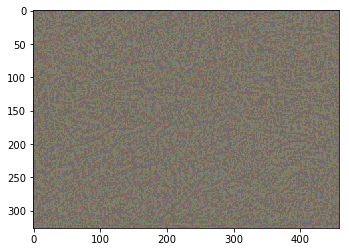

Iteration 2/100
Iteration 3/100
Iteration 4/100
Iteration 5/100
Iteration 6/100
Iteration 7/100
Iteration 8/100
Iteration 9/100
Iteration 10/100
Iteration 11/100
Iteration 12/100
Iteration 13/100
Iteration 14/100
Iteration 15/100
Iteration 16/100
Iteration 17/100
Iteration 18/100
Iteration 19/100
Iteration 20/100
Iteration 21/100
  content loss: 1.26423e+07
    style loss: 3.42452e+06
       tv loss: 253171
    total loss: 1.632e+07


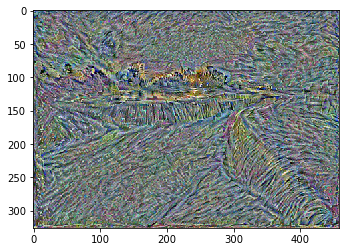

Iteration 22/100
Iteration 23/100
Iteration 24/100
Iteration 25/100
Iteration 26/100
Iteration 27/100
Iteration 28/100
Iteration 29/100
Iteration 30/100
Iteration 31/100
Iteration 32/100
Iteration 33/100
Iteration 34/100
Iteration 35/100
Iteration 36/100
Iteration 37/100
Iteration 38/100
Iteration 39/100
Iteration 40/100
Iteration 41/100
  content loss: 9.17835e+06
    style loss: 1.76997e+06
       tv loss: 210236
    total loss: 1.11586e+07


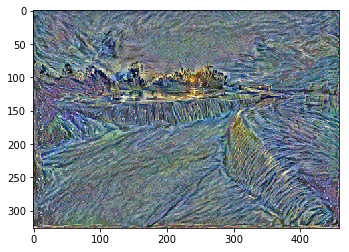

Iteration 42/100
Iteration 43/100
Iteration 44/100
Iteration 45/100
Iteration 46/100
Iteration 47/100
Iteration 48/100
Iteration 49/100
Iteration 50/100
Iteration 51/100
Iteration 52/100
Iteration 53/100
Iteration 54/100
Iteration 55/100
Iteration 56/100
Iteration 57/100
Iteration 58/100
Iteration 59/100
Iteration 60/100
Iteration 61/100
  content loss: 7.67709e+06
    style loss: 2.20046e+06
       tv loss: 185286
    total loss: 1.00628e+07


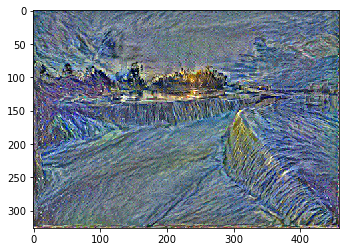

Iteration 62/100
Iteration 63/100
Iteration 64/100
Iteration 65/100
Iteration 66/100
Iteration 67/100
Iteration 68/100
Iteration 69/100
Iteration 70/100
Iteration 71/100
Iteration 72/100
Iteration 73/100
Iteration 74/100
Iteration 75/100
Iteration 76/100
Iteration 77/100
Iteration 78/100
Iteration 79/100
Iteration 80/100
Iteration 81/100
  content loss: 7.36799e+06
    style loss: 1.66199e+06
       tv loss: 170295
    total loss: 9.20028e+06


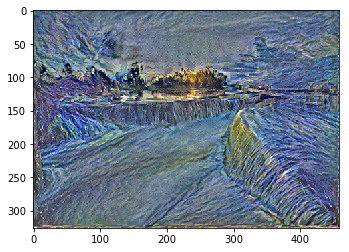

Iteration 82/100
Iteration 83/100
Iteration 84/100
Iteration 85/100
Iteration 86/100
Iteration 87/100
Iteration 88/100
Iteration 89/100
Iteration 90/100
Iteration 91/100
Iteration 92/100
Iteration 93/100
Iteration 94/100
Iteration 95/100
Iteration 96/100
Iteration 97/100
Iteration 98/100
Iteration 99/100
Iteration 100/100
  content loss: 7.37051e+06
    style loss: 1.43427e+06
       tv loss: 158391
    total loss: 8.96317e+06


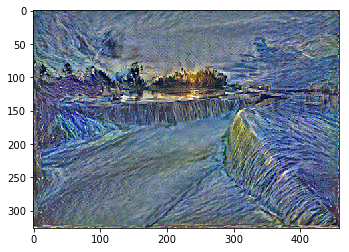

In [9]:
# default arguments
CONTENT_WEIGHT = 5e1
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e2
LEARNING_RATE = 1e1
ITERATIONS = 100
VGG_PATH = 'imagenet-vgg-verydeep-19.mat'


def load_image(image_path):
    assert exists(image_path), "image {} does not exist".format(image_path)
    img = imread(image_path)
    img = img.astype("float32")
    img = np.ndarray.reshape(img, (1,) + img.shape)
    return img

def main():
    #parser = build_parser()

    if not os.path.isfile(VGG_PATH):
        parser.error("Network %s does not exist." % VGG_PATH)

    content_image = load_image('Neural_style_export/content_image.jpg')
    style_image = load_image('Neural_style_export/style_image.jpg')

    initial = None
    if initial is not None:
        initial = scipy.misc.imresize(imread(initial), content_image.shape[:2])
    
    checkpoint_output = 'output%s.jpg'

    if checkpoint_output and "%s" not in checkpoint_output:
        parser.error("To save intermediate images, the checkpoint output "
                     "parameter must contain `%s` (e.g. `foo%s.jpg`)")
    
    use_gpu = None

    device = '/gpu:0' if use_gpu else '/cpu:0'
    

    checkpoint_iterations = 20

    style_transfer = StyleTransfer(
        vgg_path=VGG_PATH,
        content=content_image,
        style=style_image,
        content_weight=CONTENT_WEIGHT,
        style_weight=STYLE_WEIGHT,
        tv_weight=STYLE_WEIGHT,
        initial=initial,
        device=device)

    for iteration, image, losses in style_transfer.train(
        learning_rate=LEARNING_RATE,
        iterations=ITERATIONS,
        checkpoint_iterations=checkpoint_iterations
    ):
        print_losses(losses)

        output_file = None
        if iteration is not None:
            if checkpoint_output:
                output_file = checkpoint_output % iteration
        else:
            output_file = 'Neural_style_export/output.jpg'
        if output_file:
            imsave(output_file, image)


def print_losses(losses):
    stdout.write('  content loss: %g\n' % losses['content'])
    stdout.write('    style loss: %g\n' % losses['style'])
    stdout.write('       tv loss: %g\n' % losses['total_variation'])
    stdout.write('    total loss: %g\n' % losses['total'])

def imread(path):
    return scipy.misc.imread(path).astype(np.float)


def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)    
    plt.imshow(img)
    plt.show()
    scipy.misc.imsave(path, img)


if __name__ == '__main__':
    main()
